# Titanic Classifiers

Authors:
    Aaron McDaniel,
    Jeffrey Minowa,
    Joshua Reno,
    & Joel Ye

First we import all of the libraries and files we are using.

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import svm
import rfClassifier
import knnClassifier
import gnb

Next we need methods to import the data into a usable format.

In [28]:
def load_data(filename):
    url = 'data/' + filename
    df = pd.read_csv(url, sep=',')
    print("Loaded " + filename)
    return df.values

This method will read in a csv file in the data folder and convert it into an array.

In [29]:
data_dir = 'data/'
train_fn = 'train.csv'
test_fn = 'test.csv'
test_label_fn = 'gender_submission.csv'
folds = 5

def load_split_all():
    le = LabelEncoder()
    train_data = load_data(train_fn)
    test_data = load_data(test_fn)
    test_labels = load_data(test_label_fn)

    # Note test data has different data order
    # Convert sex column (col 4)
    le.fit(["male", "female"])
    train_data[:, 4] = le.transform(train_data[:, 4])
    test_data[:, 3] = le.transform(test_data[:, 3])

    # Convert embark column (col 11)
    # le.fit(["S", "C", "Q", None])
    # print(train_data[:, 11])
    # train_data[:, 11] = le.transform(train_data[:, 11])
    # test_data[:, 10] = le.transform(test_data[:, 10])
    
    # Feature selection:
    # Trim passenger_id (c0), name (c3), ticket number (c8), cabin number (c10)
    # As we're unsure about cabin_number domain effect, we're just dropping it
    # Dropping embark since we think it's not too helpful, and has NaN
    train_data = np.delete(train_data, [0, 3, 8, 10, 11], axis = 1)
    test_data = np.delete(test_data, [0, 2, 7, 9, 10], axis = 1)

    # Fill in NaN
    train_data = np.where(pd.isnull(train_data), -1, train_data)
    # test_data = np.where(pd.isnull(test_data), -1, test_data)
    x_test = np.where(pd.isnull(test_data), -1, test_data)
    y_test = test_labels

    # Separate train_data into x and y
    x_train = train_data[:, 1:].astype('float')
    y_train = train_data[:, 0].astype('int')
    return ((x_train, y_train), (x_test, y_test))


This method takes in all relevent files and creates train and test datasets that are further split up into data and labels.

Now we need methods that can evaluate and rank classifiers

In [30]:
def score(clf, data, labels):
    """
    calculates the precision and recall for the given classifier on the given set of data and labels

    :param clf: untrained classifier to be evaluated
    :param data: the dataset used for cross validation
    :param labels: the correct labels that match with the given data
    :return: a tuple of the precision and recall scores for the given classifier
    """

    precision = cross_val_score(clf, data, labels, scoring='precision', cv=5, n_jobs=-1)
    recall = cross_val_score(clf, data, labels, scoring='recall', cv=5, n_jobs=-1)
    precision = precision.mean()
    recall = recall.mean()

    return (precision, recall)

The method above will return the average precision and recall
of the inputted classifier obtained during 5-fold cross validation.

In [31]:
def convert_to_FP_FN(labels, precision, recall):
    """
    converts form precision and recall to FP and FN.
    Since Recall = TP/(TP + FN), TP = Recall * Positives
    This means we can solve for FN & FP with
    FN = TP/Recall - TP
    FP = TP/Precision - TP

    :param labels: the list of numeric labels that the precision and recall metrics came from
    :param precision: the precision of some classifier on the given labels
    :param recall: the recall of some classifier on the given labels
    :return: a tuple containing FP and FN in that order
    """
    positives = sum([1 for l in labels if l == 1])
    
    return (fp, fn)

Since score returns precision and recall, the above method converts
those metrics to False positives and false negatives with added
information from the dataset labels.

In [32]:
def pareto_dominance_min(ind1, ind2):
    """
    returns true if ind1 dominates ind2 by the metrics that should be minimized

    :param ind1: tuple of FP and FN
    :param ind2: tuple of FP and FN
    :return: boolean representing if ind1 dominates ind2 using the metrics that should be minimized
    """

    not_equal = False
    for value_1, value_2 in zip(ind1, ind2):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal


The method above will return a boolean representation of if ind1 
is pareto dominant compared to ind2 assuming that the 2 scores 
assiciated with each individual should be minimized.

In [33]:
def update_front(front, ind, comp):
    """
    Makes a new pareto front out of the old pareto front and new individual
    In this context an individual consists of scores and their hyper parameters
    For example ind[0] is a tuple of precision and recall scores
    and ind[1] is a list of the hyper-parameters needed to recreate the classifier

    :param front: the old pareto front to be updated
    :param ind: the new individual that may or may not change the old pareto front
    :param comp: the method used to compare individuals as being pareto dominant or not
    :return: the new pareto front
    """
    # A member belongs on the front if it dominates or is not dominated by new ind
    # New ind belongs on front if it is not dominated by any
    # If new ind dominated, rest of front won't be dominated
    newFront = []
    isNewDominated = False
    for i in range(len(front)):
        old = front[i]
        if comp(old[0], ind[0]): # Careful to compare the scores
            isNewDominated = True
            break
        if not comp(ind[0], old[0]):
            newFront.append(old)
    if isNewDominated:
        newFront.extend(front[i:]) # add rest of old front
    else:
        newFront.append(ind)
    return newFront

The above method will return the pareto front consisting of the 
old pareto front and one new individual.

In [34]:
def find_best_rf(data, labels):
    # RF Hyperparams
    n_trees = range(5, 20)
    max_depth = range(3, 7)

    front = []
    hyperparams = (n_trees, max_depth)
    for h1 in hyperparams[0]:
        for h2 in hyperparams[1]:
            clf = RandomForestClassifier(n_estimators=h1, max_depth=h2)
            score = score(clf, data, labels)
            score = convert_to_FP_FN(labels, score[0], score[1])

            ind = [score, (h1, h2)]
            front = update_front(front, ind, pareto_dominance_min)

            # Document performance
            # print("Params\nn_trees: %d\tmax_depth: %d" % (h1, h2))
            # print("Precision: %f\tRecall: %f" % (score[0], score[1]))
            # print("*********************************************")
    return generate_RF_front(front)

def generate_RF_front(front):
    # implements svms for each point on the pareto front
    # returns a list of SVMs
    models = []
    for ind in front:
        clf = RandomForestClassifier(n_estimators=ind[1][0], max_depth=ind[1][1])
        models += [clf]
    return models


The above methods will find an optimal pareto front for the random forrest classifier

In [35]:
def find_best_SVM(data, labels):
    clf = svm.SVC()

    kernels = ['rbf']
    probabilities = [False, True]
    tols = [0.00001, 0.0001, 0.001, 0.01]
    
    front = []  # list of best scores & params

    print("starting svm search")

    # block searching for best parameters based on cross validation
    for k in kernels:
        for p in probabilities:
            for t in tols:
                #print("Params\nk: %s\tp: %s\tt: %f" % (k, p, t))

                #create and score classifier with given hyperparameters
                clf = svm.SVC(kernel=k, probability=p, tol=t)
                score = score(clf, data, labels)
                score = convert_to_FP_FN(labels, score[0], score[1])

                # keep track of paretofront
                ind = [score, (k,p,t)]
                front = update_front(front, ind, pareto_dominance_min)

                # document performance
                #print("FP: %f\tFN: %f" % (score[0],score[1]))
                #print("*********************************************")


        # return pareto front classifiers
    return generate_SVM_front(front)

def generate_SVM_front(front):
    # implements svms for each point on the pareto front
    # returns a list of SVMs
    models = []
    for ind in front:
        clf = svm.SVC(kernel=ind[1][0], probability=ind[1][1], tol=ind[1][2])
        models += [clf]
    return models


The above code will find an optimal pareto front of SVM classifiers

In [36]:
def find_best_knn(data, labels):
    neighbors = list(range(1,50))
    front = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = score(knn, data, labels)
        precision, recall = scores
        score = convert_to_FP_FN(labels, precision, recall)
        individual = [score, [k]]
        front = update_front(front, individual, pareto_dominance_min)
    
    return generate_KNN_front(front)

def generate_KNN_front(front):
    # implements svms for each point on the pareto front
    # returns a list of SVMs
    models = []
    for individual in front:
        clf = KNeighborsClassifier(n_neighbors = individual[1][0])
        models += [clf]
    return models

The above code will find the optimal pareto front of KNN classifiers

In [37]:
def gaussianNB():
    classifier = GaussianNB()
    x, y = load_split_all()
    print(cross_val_score(classifier, x[0], x[1]))
    return classifier

The above code will produce the inly available gaussian bayes net.

In [38]:
def get_fp_fn(clf, train, test):
    x_train, y_train = train
    x_test, y_test = test
    clf.fit(x_train, y_train)

    # predict the response
    preds = clf.predict(x_test)
    fp = sum([1 for i in range(len(preds)) if preds[i] == 1 and y_test[i][1] == 0])
    fn = sum([1 for i in range(len(preds)) if preds[i] == 0 and y_test[i][1] == 1])
    return (fp, fn)

The above method will return the false positives and false negatives for the given classifier

Now we can put it all together!

In [39]:
train, test = load_split_all()
train_x, train_y = train
test_x, test_y = test

Loaded train.csv
Loaded test.csv
Loaded gender_submission.csv


First we organize the data

In [40]:
rf_front = rfClassifier.find_best_rf(train_x, train_y)

Searching for best random forest


In [41]:
svm_front = svm.find_best_SVM(train_x, train_y)

Searching for best SVM


In [42]:
knn_front = knnClassifier.find_best_knn(train_x, train_y)

Searching for best knn


In [43]:
gnb_front = [gnb.gaussianNB()]

Loaded train.csv
Loaded test.csv
Loaded gender_submission.csv
[0.76094276 0.79461279 0.78451178]


Now we find our pareto fronts

In [44]:
rf_scores = np.asarray([get_fp_fn(clf, train, test) for clf in rf_front])
svm_scores = np.asarray([get_fp_fn(clf, train, test) for clf in svm_front])
knn_scores = np.asarray([get_fp_fn(clf, train, test) for clf in knn_front])
gnb_scores = np.asarray([get_fp_fn(clf, train, test) for clf in gnb_front])

We need to evaluate these clean these front results, as though they formed the pareto-front on our cross-eval'ed training, they are not necessarily all in the pareto-front for our final test set.

In [46]:
rf_true = []
for score in rf_scores:
    score = [score, ()] # dummy
    rf_true = update_front(rf_true, score, pareto_dominance_min)
rf_scores = np.asarray([np.asarray(ind[0]) for ind in rf_true])
svm_true = []
for score in svm_scores:
    score = [score, ()]
    svm_true = update_front(svm_true, score, pareto_dominance_min)
svm_scores = np.asarray([np.asarray(ind[0]) for ind in svm_true])
knn_true = []
for score in knn_scores:
    score = [score, ()]
    knn_true = update_front(knn_true, score, pareto_dominance_min)
knn_scores = np.asarray([np.asarray(ind[0]) for ind in knn_true])

# Sort scores so they display pseudo HoF
rf_scores = rf_scores[np.argsort(rf_scores[:, 0])]
svm_scores = svm_scores[np.argsort(svm_scores[:, 0])]
knn_scores = knn_scores[np.argsort(knn_scores[:, 0])]


Now we can graph our results

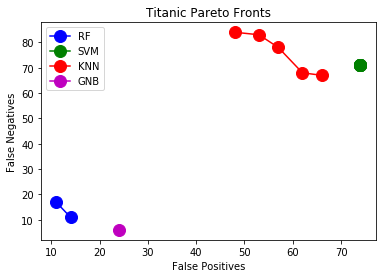

In [48]:
fig, ax = plt.subplots()
ax.set_title("Titanic Pareto Fronts")
ax.plot(rf_scores[:,0], rf_scores[:,1], c='b', marker='o', markersize='12', label='RF')
ax.plot(svm_scores[:, 0], svm_scores[:, 1], c='g', marker='o', markersize='12', label='SVM')
ax.plot(knn_scores[:, 0], knn_scores[:, 1], c='r', marker='o', markersize='12', label='KNN')
ax.plot(gnb_scores[:,0], gnb_scores[:,1], c='m', marker='o', markersize='12', label='GNB')
# ax.plot(gnb_scores[:, 0], gnb_scores[:, 1], c='m', label='GNB')
plt.xlabel("False Positives")
plt.ylabel("False Negatives")
ax.legend()
plt.show()


SHOW ME THE GRAPHS